In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import os
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import xgboost as xgb
import shap

C:\Users\adity\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# These are relative paths. Replace paths with your own paths
TRANSACTION_DF_PATH = r"customer_transaction_info.json" 
PRODUCT_INFO_PATH = r"product_info.json"   
CUSTOMER_INFO_PATH = r"customers_info.json"
ORDERS_RETURNED_PATH = r"orders_returned_info.json"
REGION_SELLER_INFO_PATH= r"region_seller_info.json"

In [3]:
def getOrdersReturned(file_path=ORDERS_RETURNED_PATH):
    file_path = Path(file_path).resolve()

    try:
        with open(file_path, 'r') as jsonFile:
            jsonData = json.load(jsonFile)
        

        indexes = list(jsonData.keys())
        
        # Extracting column names
        jsonItems = list(jsonData.items())
        columns = list(jsonItems[0][1].keys())

        # Creating empty pandas dataframe
        order_returned_df = pd.DataFrame(columns=columns)

        for i in range(0, len(jsonItems)):
            itmeDict = dict(jsonItems[i][1].items())
            for key,item in itmeDict.items():
                order_returned_df.loc[i, key] = item
        

        return order_returned_df


        
    except Exception as e:
        print(e)

In [4]:
def getTransactionDetails(json_file_path=TRANSACTION_DF_PATH):

    # Using pathlib.Path to handle file paths
    json_file_path = Path(json_file_path).resolve()

    try:
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        
        # There are 3 fields in which data is stored in this json file: columns, index, data
        # We will extract column names and indexes in seperate lists and for data, we will prepare a list of lists.
        # It will help us to prepare a pandas dataframe to work with later on.

        column_names = data['columns']
        indexes = data['index']

        # Extracting all data rows
        dataObjets = data['data']
        dataRows = []

        for i in range(0, len(dataObjets)):
            dataRows.append(dataObjets[i])

        # Creating a pandas dataframe 
        customer_transaction_df = pd.DataFrame(dataRows, columns=column_names, index=indexes)

        return customer_transaction_df


    
    except Exception as e:
        pass
    except FileNotFoundError as e:
        print(e)
    
    
    

In [5]:
def getProductDetails(file_path=PRODUCT_INFO_PATH):
    file_path = Path(file_path).resolve()

    try:
        with open(file_path, 'r') as jsonFile:
            data = json.load(jsonFile)
        
        schemaFields = data['schema']['fields']
        column_names = []

        dataObjects = data['data']

        for i in range(0, len(schemaFields)):
            column_names.append(schemaFields[i]['name'])

        product_df = pd.DataFrame(data=dataObjects, columns=column_names)

        return product_df

        

    except Exception as e:
        print(e)
    

In [6]:
def getCustomerInfo(file_path=CUSTOMER_INFO_PATH):

    file_path = Path(file_path).resolve()

    try:
        with open(file_path, 'r') as jsonFile:
            data = json.load(jsonFile)

        column_names = list(data[0].keys())
        dataObjects = []

        for i in range(0, len(data)):
            temp = []
            for keys in data[i]:
                temp.append(data[i][keys])
            
            dataObjects.append(temp)
        

        customer_info_df = pd.DataFrame(data=dataObjects, columns=column_names)
        return customer_info_df

    except Exception as e:
        print(e)

In [7]:
def preProcessProducts():
    """ 
    From initial observations,some of the productIDs are repeating in this dataset, althought the product names are different. Since, they're creating ambiguity in transactional information, we came up with following modifications:

    * Appended '-x' string at the end of each productID, where x is an integer. Initially, all 'unique' productIDs will have the x value to be 0.
    * As we encounter duplicate entries of same productID, we will go on incrmenting value of 'x' 
    * This will be our variantID. 

    The way transaction data is being handled, there's no room for duplicate productID entries to exist for same orderID and customerID combination.

    """
    product_info_df = getProductDetails(PRODUCT_INFO_PATH)

    product_info_df_sorted = product_info_df.sort_values(by="Product ID", ascending=True).reset_index(drop=True)

    def fixProductIDs():
        productID_count = {}
        modified_IDs = []

        for index, row in product_info_df_sorted.iterrows():
            # Get the corresponding productID for each row
            productID = row["Product ID"]

            if productID in productID_count:
                productID_count[productID] += 1
            else:
                productID_count[productID] = 0

            modified_IDs.append(f"{productID}-{productID_count[productID]}")            
        
        product_info_df_sorted["variant_id"] = modified_IDs
        

    

    fixProductIDs()

    product_info_df_sorted = product_info_df_sorted.rename(columns={'Product ID' : 'Old Product ID', 'variant_id': 'Product ID'})
    return product_info_df_sorted
        


    

    

In [8]:
def preProcessTransactions(transactions_info_df: pd.DataFrame):
    """
    Some records were found to have same [OrderID, CustomerID, ProductID] combination with different values for Quantity
    To resolve this issue, we decided to aggregate these differing features such as Profit, Quantity bought and Sales amount by summing them up

    """
    try:
        columns_to_check = [
            "Order ID",
            "Order Date",
            "Ship Date",
            "Ship Mode",
            "Customer ID",
            "Product ID",
            "Discount",
        ]
        temp_merged_quantity_df = transactions_info_df.groupby(
            columns_to_check, as_index=False
        ).agg({"Quantity": "sum", "Sales": "sum", "Profit": "sum"})

        transactions_info_df = temp_merged_quantity_df

        """ 
        2] The order and shipping dates are in UNIX timestamp format. During model training, how to use these dates becomes a question. Instead, we will be converting these dates to the ususal date-time format, and extracting the no of days have passed since the particular item was last bought

        This could prove to be crucial for predictive analytics.

        """

        current_date = datetime.today().date()
        transactions_info_df["Order_date_modified"] = transactions_info_df[
            "Order Date"
        ].apply(lambda x: pd.to_datetime(x, unit="ms").date())

        transactions_info_df["last_ordered"] = transactions_info_df[
            "Order_date_modified"
        ].apply(lambda x: (current_date - x).days)

        transactions_info_df = transactions_info_df.drop(
            columns=["Order_date_modified", "Order Date", "Ship Date"]
        )

        """ 
        Reading the orders_returned data into a dataframe.

        """
        orders_returned_df = getOrdersReturned(
            ORDERS_RETURNED_PATH
        )

        temp_merged_df = transactions_info_df.merge(
            orders_returned_df, on="Order ID", how="outer"
        )

        temp_merged_df["Returned"] = temp_merged_df["Returned"].fillna("No")
        transactions_info_df = temp_merged_df


        """ 
        After we have created a variantID for each repeating productID, we need to make subsequent changes for productIDs in the transactions table too.
        * Since there's no way as of now to understand the business logic behind the which product was bought from the products falling under the same productID, the idea is to replace it with first occurence of variantID in the product Info table
    
        """
        product_df = preProcessProducts()
        variant_mappings = product_df.groupby("Old Product ID")["Product ID"].first().to_dict()
        transactions_info_df["Product ID"] = transactions_info_df["Product ID"].map(variant_mappings).fillna(transactions_info_df["Product ID"])

        # Performing left join on transaction data with the product information

        temp_joined_df = transactions_info_df.merge(product_df, on="Product ID", how="inner")
        temp_joined_df = temp_joined_df.drop(columns=["Old Product ID", "index"])



        
        transactions_info_df = temp_joined_df
        

        return transactions_info_df
    except Exception as e:
        print(e)

In [9]:
def prepareDataFeatures(df, product_ids):
    lc = LabelEncoder()
    df["Customer ID"] = lc.fit_transform(df["Customer ID"])
    customer_features = df.groupby("Customer ID").agg({
    'Sales' : ['sum', 'mean', 'count'],
    'Profit' : ['sum', 'mean'],
    'Discount' : ['mean'],
    'Quantity' : ['sum', 'mean'],
    'Returned' : lambda x : (x == "Yes").mean()
}).reset_index()
    
    customer_features.columns = ['Customer ID'] + [
        f'{col[0]}_{col[1]}'.lower() for col in customer_features.columns[1:]
    ]

    df = df.drop(columns=["Order ID"])

    # Getting all customers 
    all_customers = df["Customer ID"].unique()

    # Filtering those customers which have bought products provided in the list of product_ids above.
    target_purchases = df[df["Product ID"].isin(product_ids)]
    customers_with_target = target_purchases["Customer ID"].unique()

    y = pd.Series(index=all_customers, data=0)
    y[customers_with_target] = 1


    X = customer_features.set_index("Customer ID")


    # Renaming columns to ensure consistency while training XGBoost Model
    X = X.rename(columns={'sales_sum' : 'salesSum', 'sales_mean': 'salesMean', 'sales_count': 'salesCount', 'profit_sum' : 'profitSum', 
                      'profit_mean': 'profitMean', 'discount_mean': 'discountMean', 'quantity_sum': 'quantitySum', 'quantity_mean': 'quantityMean', 'returned_<lambda>': 'returnedRate'})
    
    X = X.reindex(all_customers)
    y = y.reindex(all_customers)

    
    return X, y, lc
    




In [10]:
def trainXGBModel(X, y):


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y) 
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    feature_names = X.columns


    dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=list(X.columns))
    dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=list(X.columns))

    params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 6,
            'eta': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1) 
        }
    

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    y_pred = (model.predict(dtest) > 0.5).astype(int)

    model_accuracy = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    return model, scaler, feature_names, model_accuracy

        

In [11]:
def getPredictions(model, scaler, feature_names, customer_features):
    # customer_features = customer_features[feature_names]
    X_scaled = scaler.transform(customer_features)
    dpredict = xgb.DMatrix(X_scaled, feature_names=list(feature_names))
    probabilities = model.predict(dpredict)
    return pd.Series(probabilities, index=customer_features.index)

In [12]:
def getRelatedProducts(product_info_df, keyword, top_n=30):


    product_info_df["Product_info"] = product_info_df["Category"] + " " + product_info_df["Product Name"] + " " + product_info_df["Sub-Category"]


    vectorizer = TfidfVectorizer(stop_words=None, max_features=7000)
    feature_vectors = vectorizer.fit_transform(product_info_df["Product_info"])


    keyword_vector = vectorizer.transform([keyword])

    if keyword_vector.sum() == 0:
        print("Warning: Keyword not found in vocabulary!")
        return []

    similarities = cosine_similarity(keyword_vector, feature_vectors).flatten()


    top_indices = similarities.argsort()[::-1][:top_n]

    # results = [(transaction_df_2.iloc[i]["Product ID"], transaction_df_2.iloc[i]["Product Name"], similarities[i]) for i in top_indices]
    results = [product_info_df.iloc[i]["Product ID"] for i in top_indices]
    results = list(set(results))



    return results

In [13]:
def main(customer_id, keyword):
    df = getTransactionDetails(TRANSACTION_DF_PATH)
    df = preProcessTransactions(df)

    product_info_df = df.drop(columns=['Order ID', 'Ship Mode', 'Customer ID', 'Discount','Quantity', 'Sales', 'Profit', 'last_ordered', 'Returned'])

    product_ids = getRelatedProducts(product_info_df, keyword)


    X, y, customer_label_enc = prepareDataFeatures(df, product_ids)

    model, scaler, feature_names, accuracy = trainXGBModel(X, y)

    # using SHAP on the XGB Model
    explainer_xgb = shap.Explainer(model, X)
    shap_values_xgb = explainer_xgb(X)

    # ✅ Summary Plot (Feature Importance)
    shap.summary_plot(shap_values_xgb, X)

    probabilities = getPredictions(model, scaler, feature_names, X)

    print(f"Accuracy score of XGBoost Model: {accuracy}")
    customer_id = int(customer_label_enc.transform([customer_id]))
    
    if customer_id in probabilities.index:
        return probabilities[customer_id]
    else:
        return 0

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       153
           1       0.00      0.00      0.00         6

    accuracy                           0.87       159
   macro avg       0.48      0.45      0.47       159
weighted avg       0.92      0.87      0.90       159



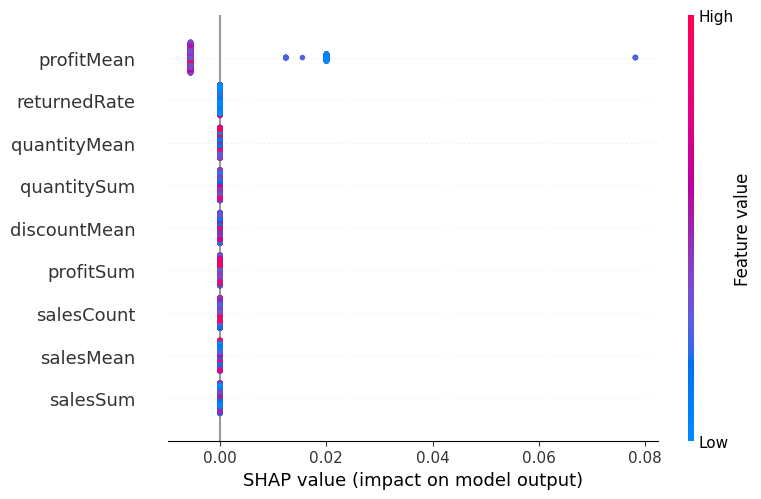

Accuracy score of XGBoost Model: 0.8742138364779874

0.104860775


C:\Users\adity\AppData\Local\Temp\ipykernel_21048\671988785.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  customer_id = int(customer_label_enc.transform([customer_id]))


In [14]:
probability = main('DV-13045', 'Printer')
print()
print(probability)